In [1]:
import cv2 as cv

import numpy as np 

import pandas as pd 

import plotly.express as px 

import matplotlib.pyplot as plt

import os 

import skimage

import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm 

from matplotlib import cm

from matplotlib.patches import Circle

from skimage.feature import hog
from skimage import data, exposure

%matplotlib inline

In [2]:
df_n_standard = pd.read_csv('Non_Segmented_Features_Standardized.csv')
df_s_standard = pd.read_csv('Segmented_Features_Standardized.csv')


## For all images, calculate the LAB Channel Mean and Stds 

In [3]:
# # Mean Value array for channels
# Lm = [] 
# Am = []
# Bm = []
# # Standard Deviation array for channels
# Ls = []
# As = []
# Bs = []

# for index, row in df_s_standard.iterrows():
    
#     src = cv.imread(row['root'])
    
#     imgLAB = cv.cvtColor(src, cv.COLOR_BGR2Lab)
    
#     #Add average channels to mean channel array 
#     Lm.append(imgLAB[:,:,0].mean())
#     Am.append(imgLAB[:,:,1].mean())
#     Bm.append(imgLAB[:,:,2].mean())
    
#     #Add average channels to mean channel array 
#     Ls.append(imgLAB[:,:,0].std())
#     As.append(imgLAB[:,:,1].std())
#     Bs.append(imgLAB[:,:,2].std())
    
# print(np.array(Lm).mean(), np.array(Ls).mean(), np.array(Am).mean(), np.array(As).mean(), np.array(Bm).mean(), np.array(Bs).mean())

## Standardization / Pre Process Method

In [31]:
def pre_process(source, segmented, verbose = False):
    
    """Pre Process in following steps:
    
    Source: https://www.mdpi.com/1424-8220/14/9/16128
    
    1 - Convert Image to LAB 
    2 - Mean center, standard deviation normalize image channels 
        Non-segmented:
            L mean, std: 222.08854714696653 30.02476962150579
            A mean, std: 130.44992887933736 10.723476763696134
            B mean, std: 116.46949092388897 15.550995691036182
        Segmented: 
            L mean, std: 15.277906841627546 40.29812550409032
            A mean, std: 133.02456854941858 13.046152624476061
            B mean, std: 127.5289774404416 2.495164941985654
    3 - Noise Reduce 
    4 - Adaptive Histogram Equalization"""
    
    if segmented: 
        
        means = [15.28,130.02, 127.53]
        stds = [40.30,13.05, 2.49]
        
    else: 
        
        means = [222.09,130.44, 116.47]
        stds = [30.02,10.72, 15.55]
        
        
    src = cv.imread(source)
    
    if not segmented: 
        src = cv.cvtColor(src, cv.COLOR_RGB2BGR)
    #
    #Step1
    imgLAB = cv.cvtColor(src, cv.COLOR_BGR2Lab)
    imgLAB2 = cv.cvtColor(src, cv.COLOR_BGR2Lab).astype('float')
    #Step 2 mean-standard deviation normalize
    for i in [0,1,2]:
        
        std = imgLAB[:,:,i].std()
#         imgLAB2[:,:,i] -= means[i]
            
        imgLAB2[:,:,i] *= (std/stds[i])
        
    #step 3 Noise Reduce 
    imgLAB2 = imgLAB2.astype('uint8')
    imgLAB_blur = cv.medianBlur(imgLAB2, 3)
    
    #Step 4 Histogram Equalize
    R, G, B = cv.split(imgLAB_blur)

    output1_R = cv.equalizeHist(R)
    output1_G = cv.equalizeHist(G)
    output1_B = cv.equalizeHist(B)

    imgLAB_he = cv.merge((output1_R, output1_G, output1_B))
    
    if verbose: 
        
        fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16,4))
        
        ax[0].imshow(src)
        ax[0].set_title('original image')
        
        ax[1].imshow(imgLAB)
        ax[1].set_title('LAB image')
        
        ax[2].imshow(imgLAB2)
        ax[2].set_title('Normalized image')
        
        ax[3].imshow(imgLAB_blur)
        ax[3].set_title('Blurred image')
        
#         ax[4].imshow(imgLAB_he)
#         ax[4].set_title('Histogram Equalized')
        
        fig.show()
        
    return imgLAB_blur

/var/folders/94/bxh7fj4x7yl9kbsd9mrp4n740000gn/T/ipykernel_33696/2574131238.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


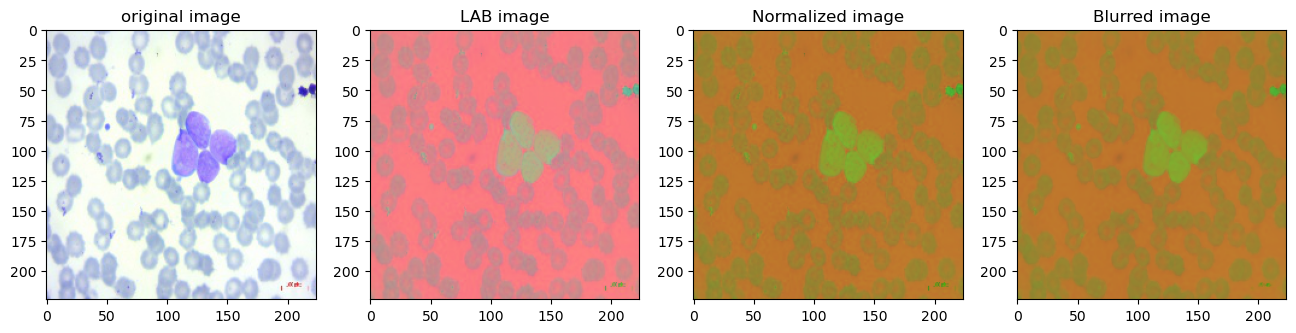

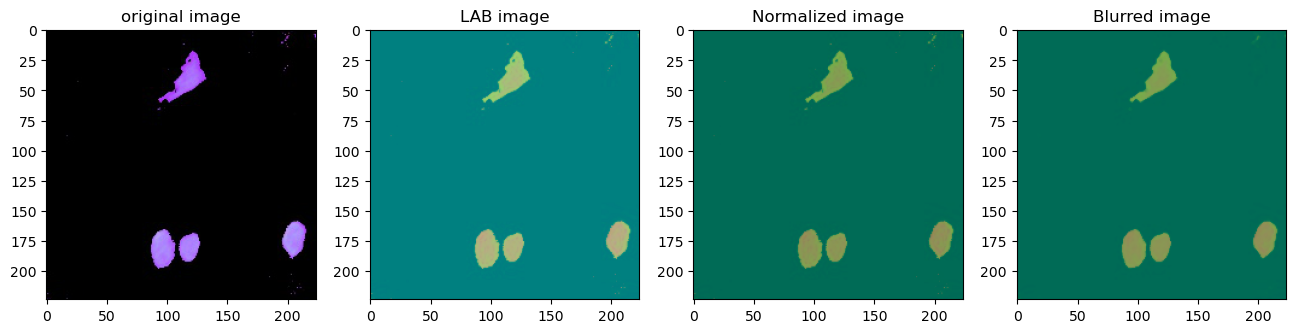

In [32]:
for index, row in df_n_standard.iterrows():
    
    src = pre_process(row['root'], segmented = False, verbose = True)
    
    
    break
    
for index, row in df_s_standard.iterrows():
    
    src = pre_process(row['root'], segmented = True, verbose = True)
    
    
    break

In [6]:
## Okay this appears to work lets impliment the features we have

In [25]:
def Contour_Data(img, label, thresh, segmented, bounded = True , verbose = False):
    
    src_gray = cv.imread(img, cv.IMREAD_GRAYSCALE)
    
    img = pre_process(img, segmented, verbose = False)
    
#     img = img.mean(axis = 2)
#     img = img.astype('uint8')
#     img = cv.medianBlur(img, 3)
    
    # Detect edges using Canny
    canny_output = cv.Canny(img, thresh, thresh * 2)
    # Find contours
    contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Draw contours
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    
    if verbose: 
        
        for i in range(len(contours)):

            color = (np.random.randint(0,256), np.random.randint(0,256), np.random.randint(0,256))
            if cv.contourArea(contours[i]) > 25:
                cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)

        fig, ax = plt.subplots(nrows = 1,ncols =4, figsize = (16,4))
        ax[0].imshow(src_gray, cmap = 'gray')
        ax[1].imshow(img, cmap = 'gray') 
        ax[2].imshow(canny_output, cmap = 'gray')
        ax[3].imshow(drawing)

        fig.suptitle(f'{label}')
        fig.show()


    areas = []
    count = 0
    
    for i in contours:
        
        if bounded: 
            
            area = cv.contourArea(i, True) #If True: signed areas (+ = closed contours), if False: unsigned areas (all contours)
            
        else: 
            area = cv.contourArea(i)
            
        if area > 25:
            
            areas.append(area)
            count += 1

    area = np.array(areas)
    
    return area.sum(), area.mean(), area.std(), count

In [8]:
df_n_standard.head()

root                         base  \
0  Original/Early/WBC-Malignant-Early-384.jpg  WBC-Malignant-Early-384.jpg   
1  Original/Early/WBC-Malignant-Early-390.jpg  WBC-Malignant-Early-390.jpg   
2  Original/Early/WBC-Malignant-Early-409.jpg  WBC-Malignant-Early-409.jpg   
3  Original/Early/WBC-Malignant-Early-347.jpg  WBC-Malignant-Early-347.jpg   
4  Original/Early/WBC-Malignant-Early-421.jpg  WBC-Malignant-Early-421.jpg   

   class  split class name  
0      2  train      Early  
1      2  train      Early  
2      2  train      Early  
3      2  train      Early  
4      2  train      Early

/var/folders/94/bxh7fj4x7yl9kbsd9mrp4n740000gn/T/ipykernel_33696/622478529.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/94/bxh7fj4x7yl9kbsd9mrp4n740000gn/T/ipykernel_33696/622478529.py:55: RuntimeWarning: Mean of empty slice.
  return area.sum(), area.mean(), area.std(), count
/var/folders/94/bxh7fj4x7yl9kbsd9mrp4n740000gn/T/ipykernel_33696/622478529.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows = 1,ncols =4, figsize = (16,4))


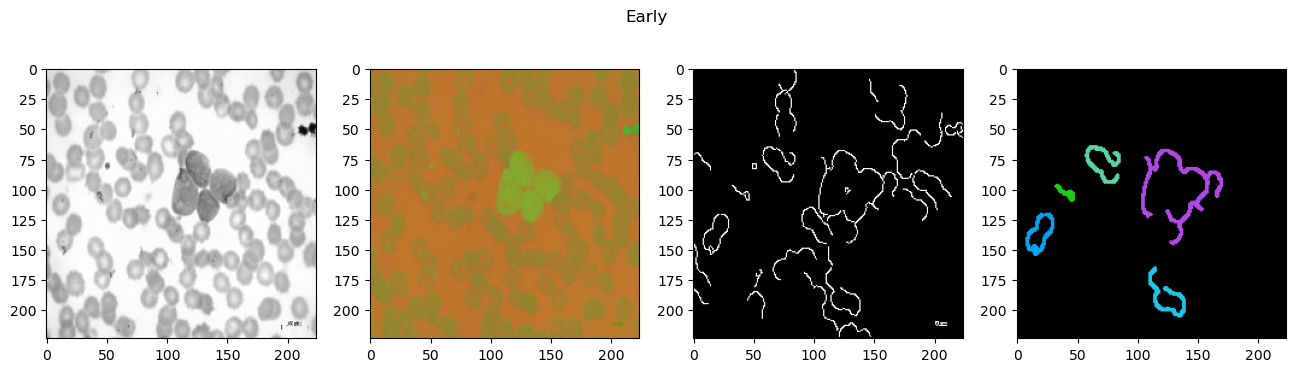

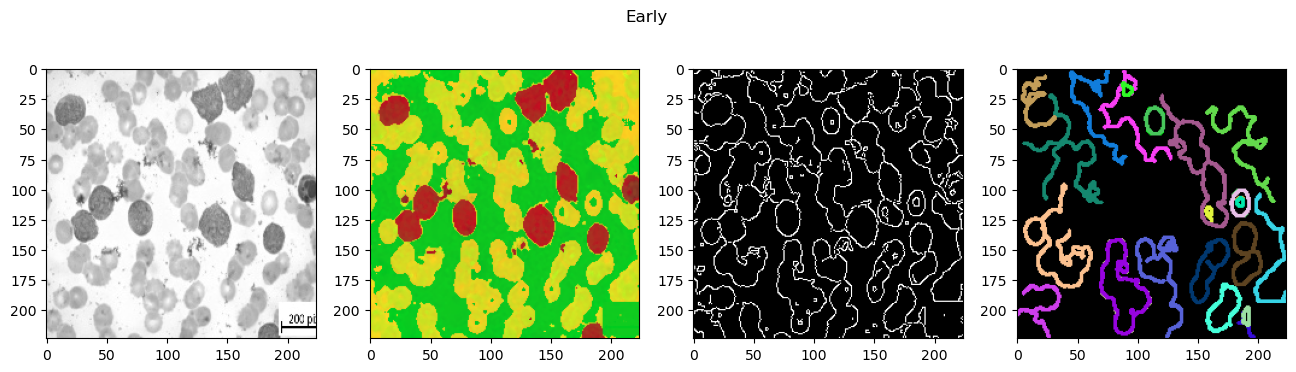

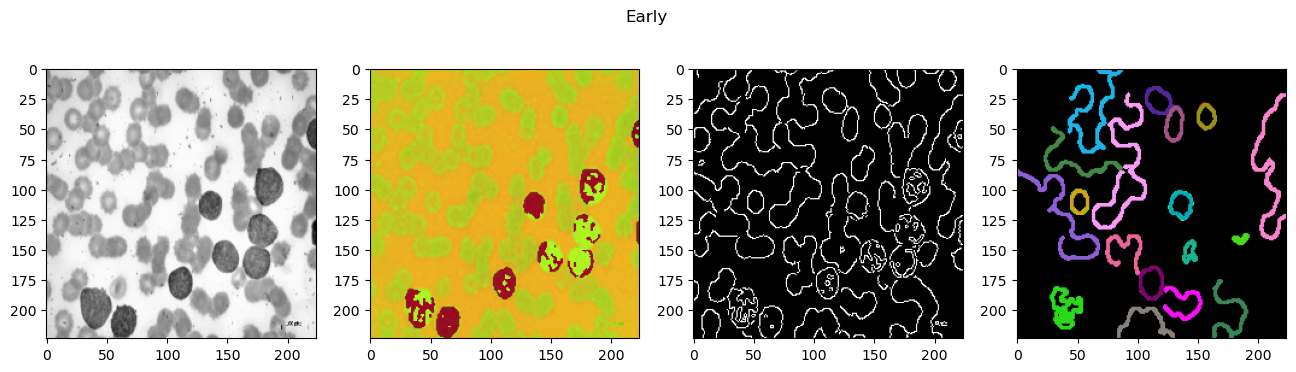

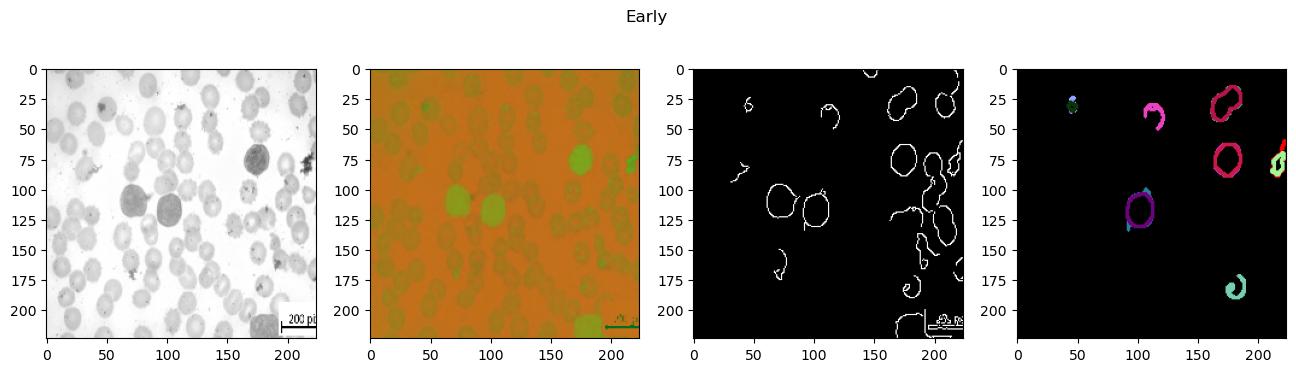

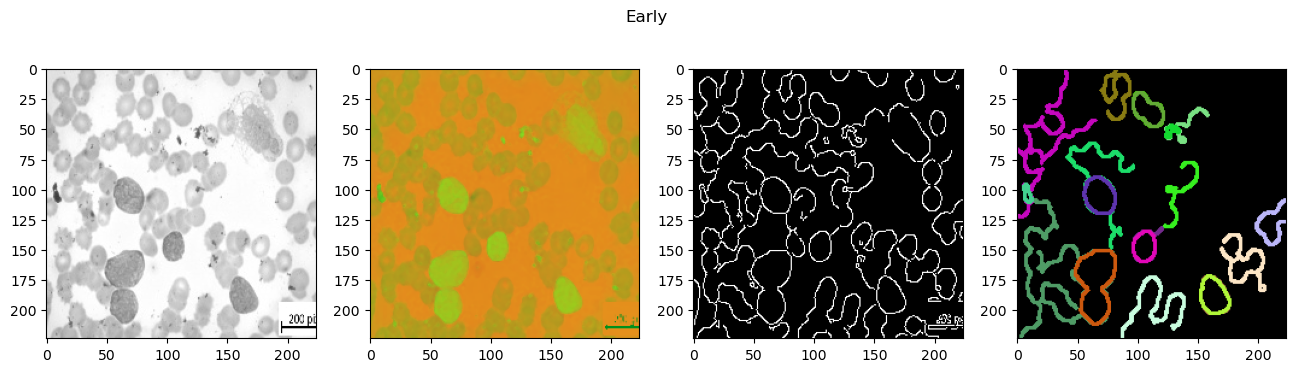

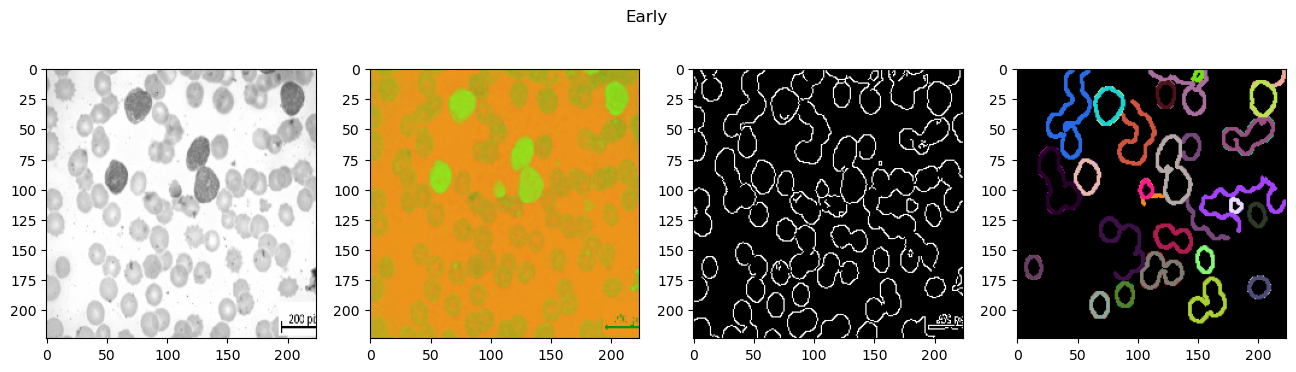

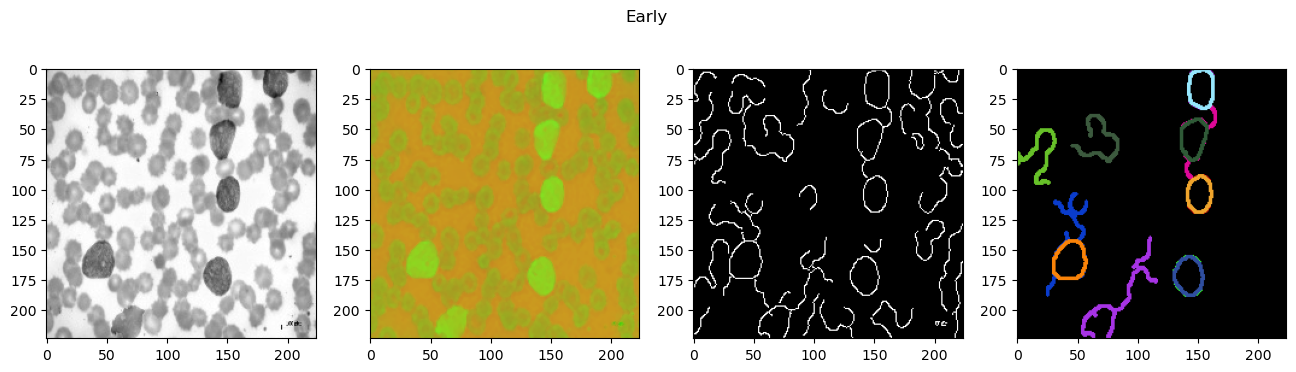

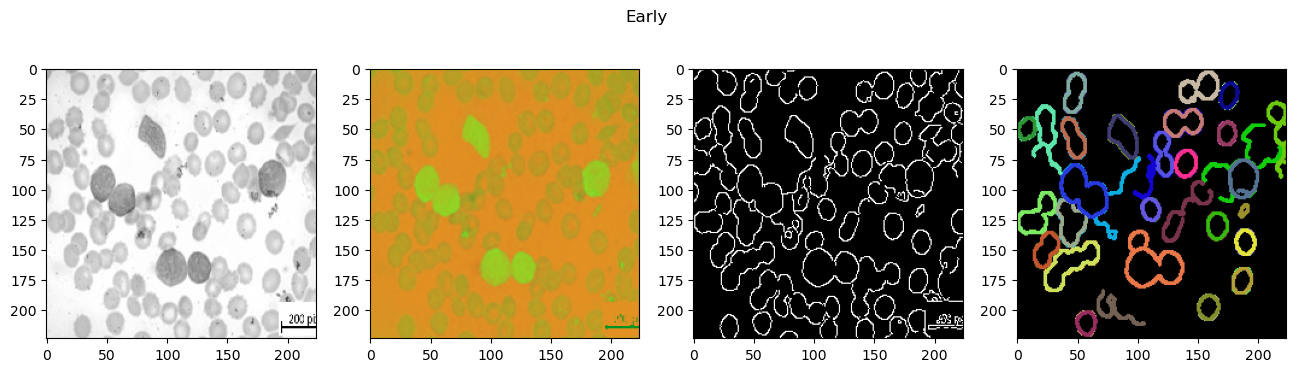

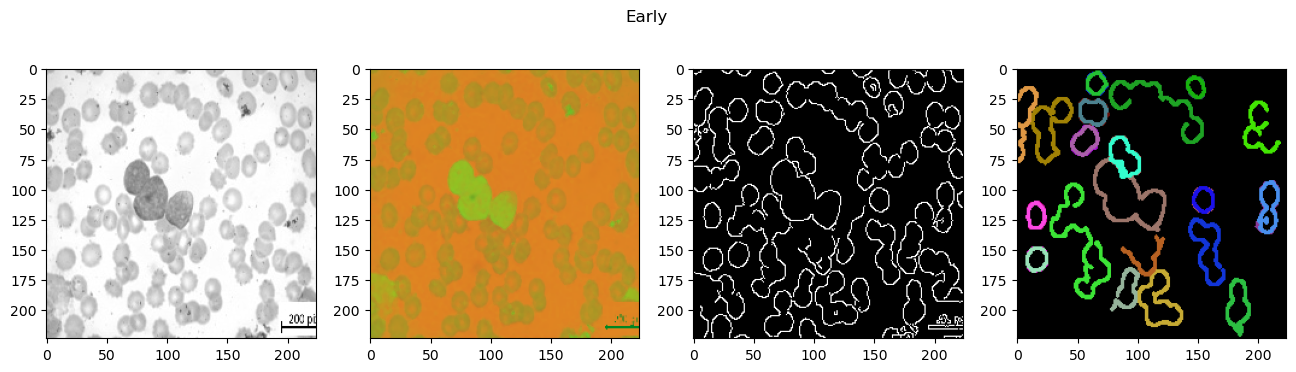

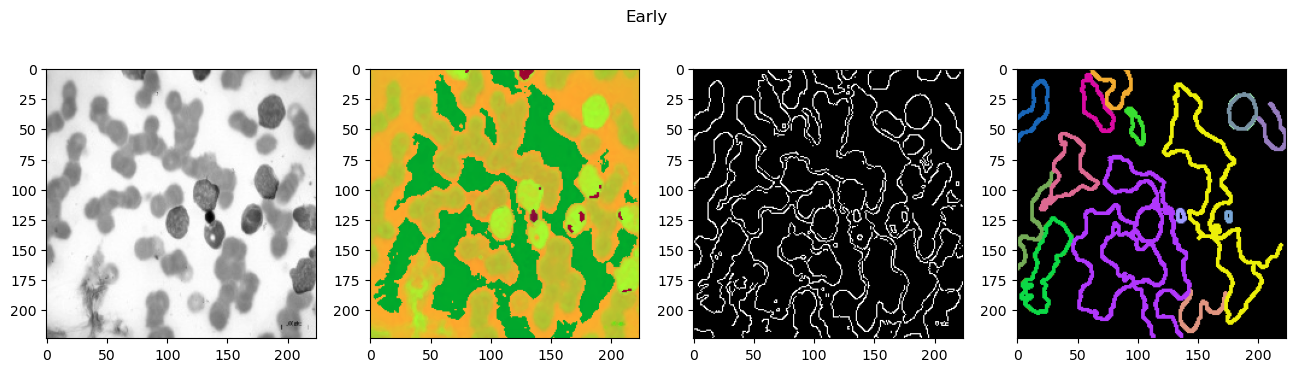

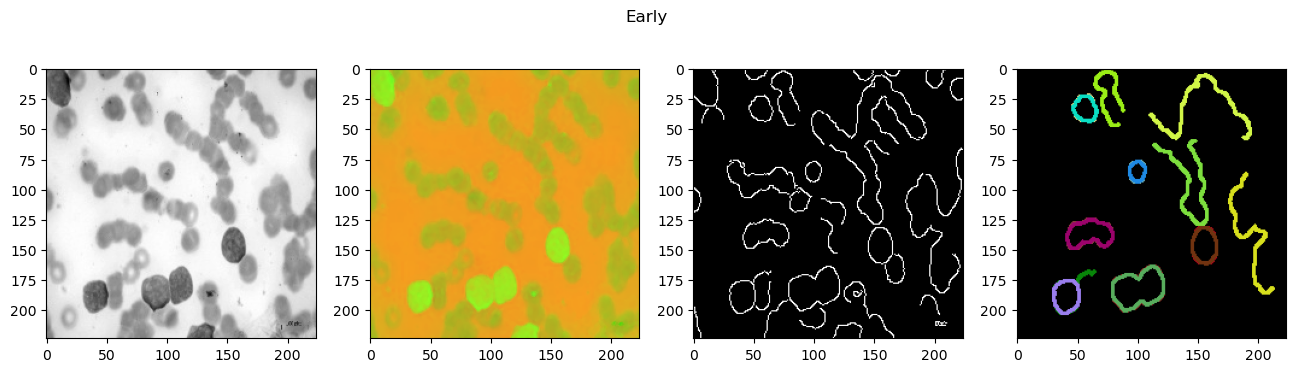

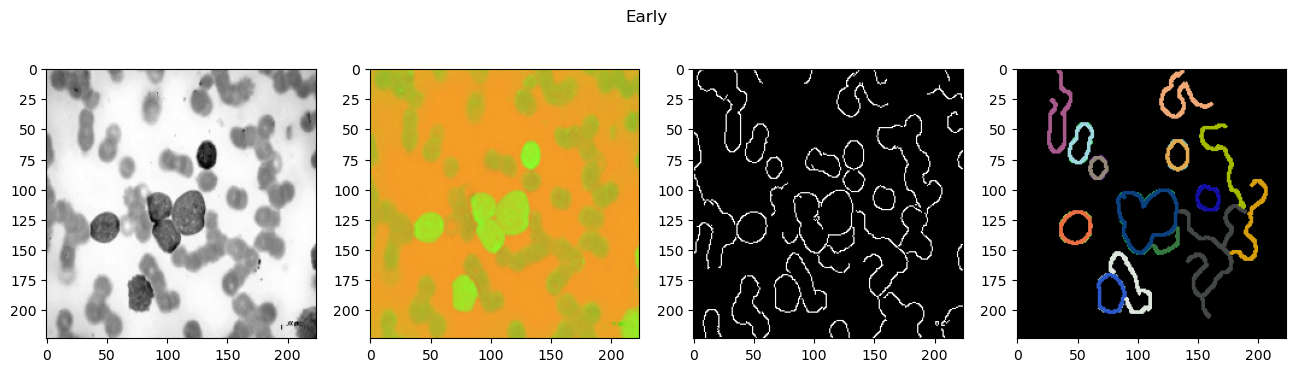

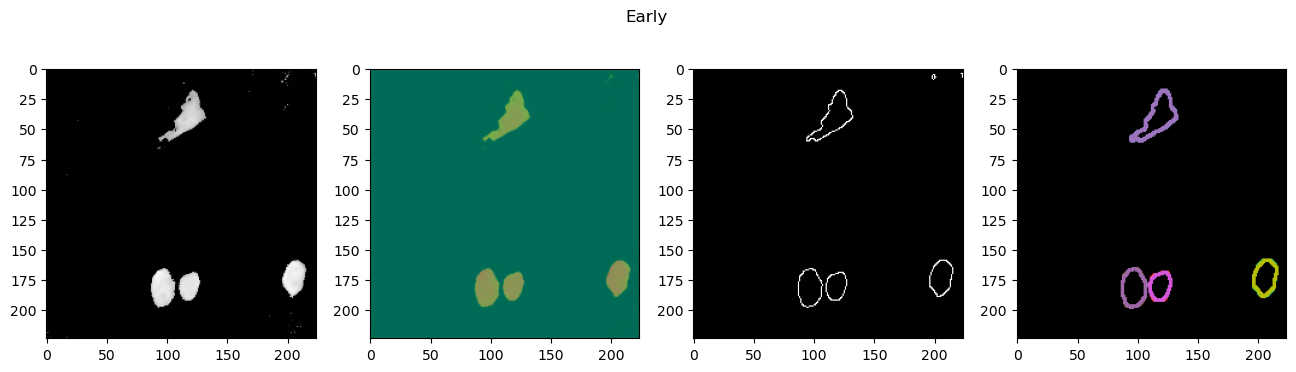

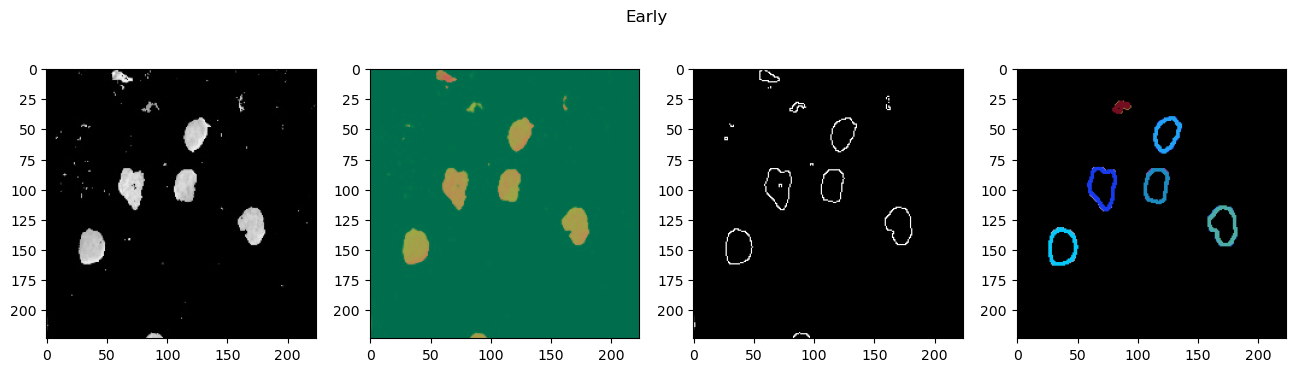

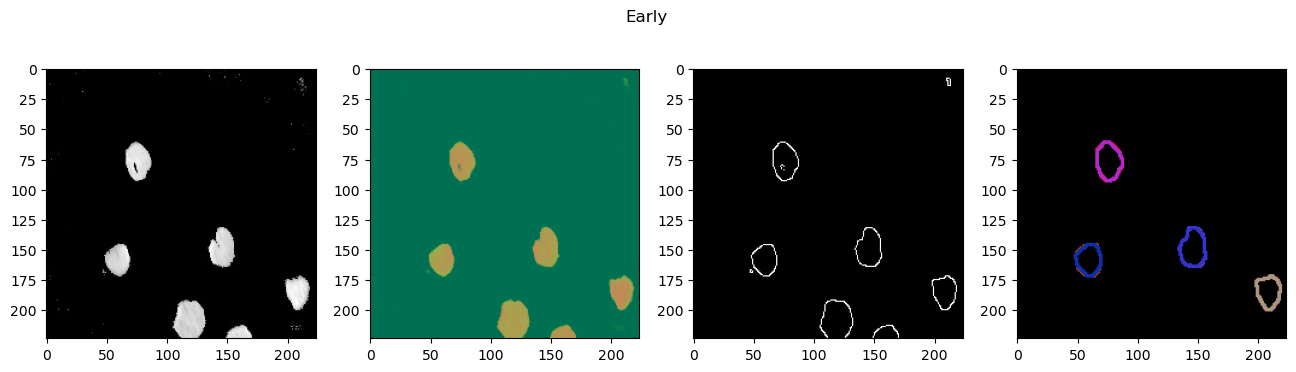

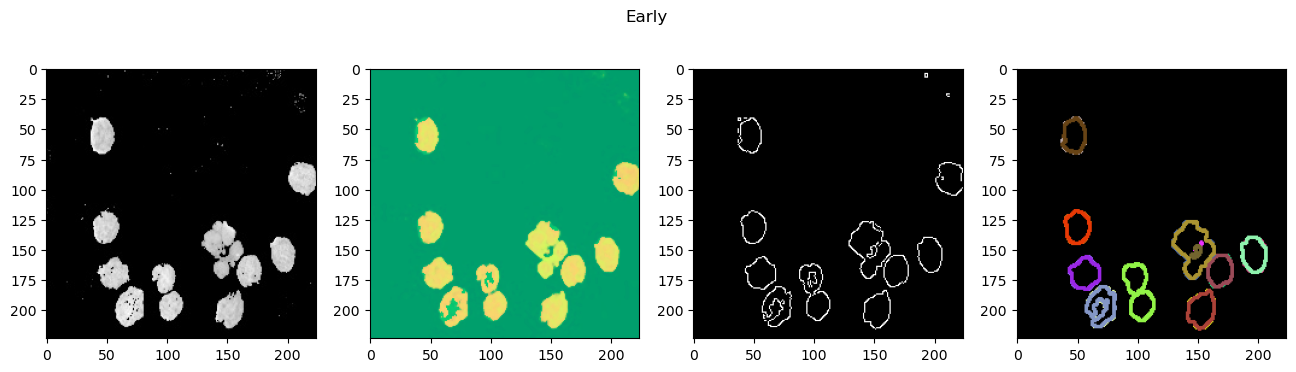

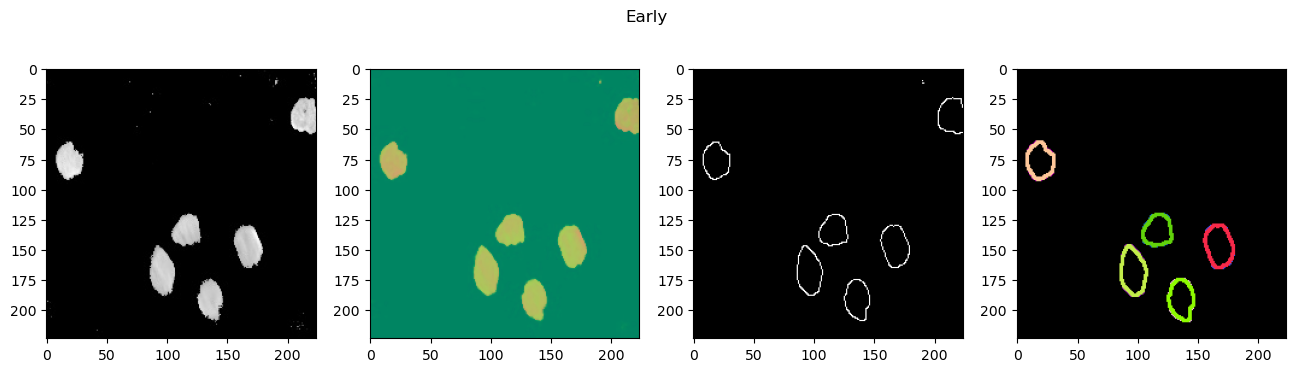

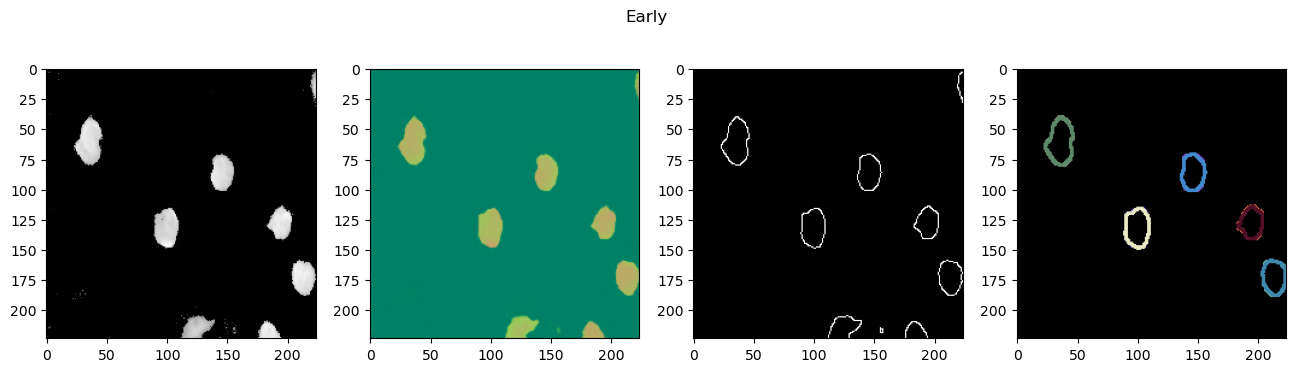

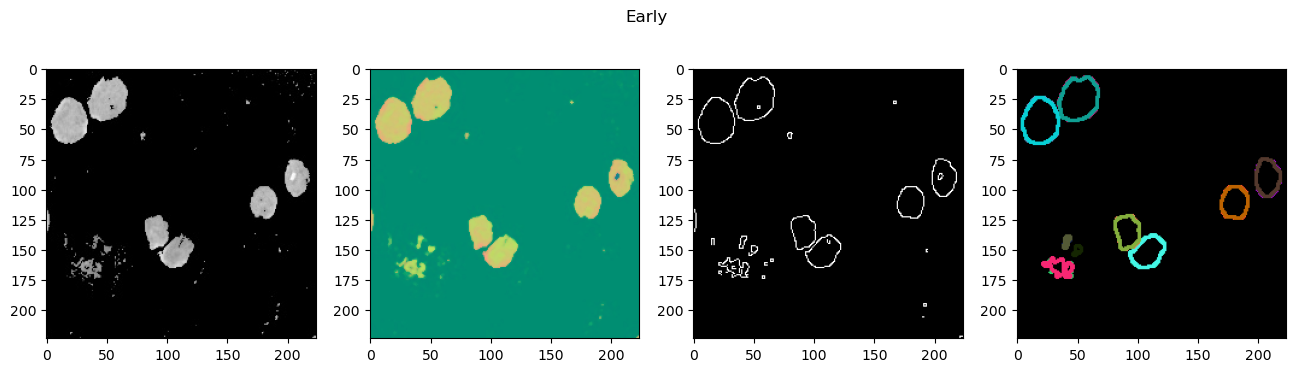

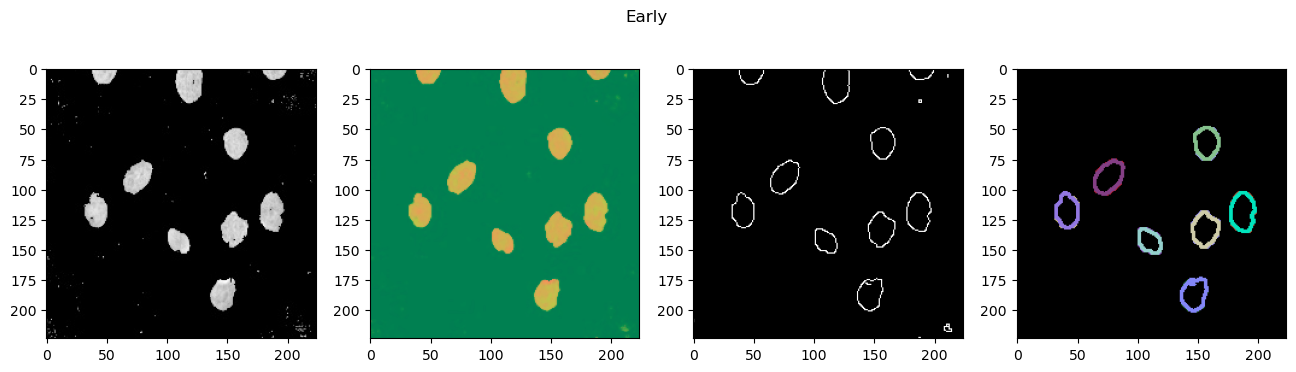

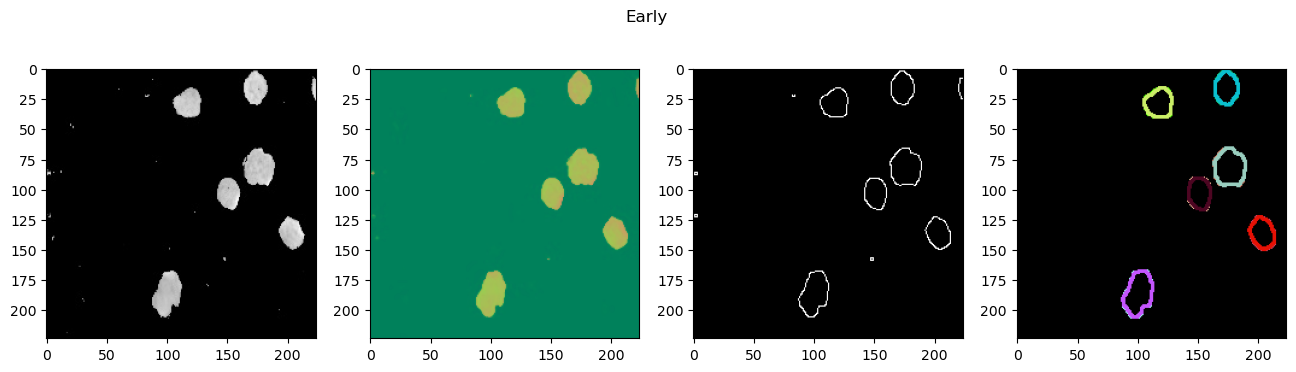

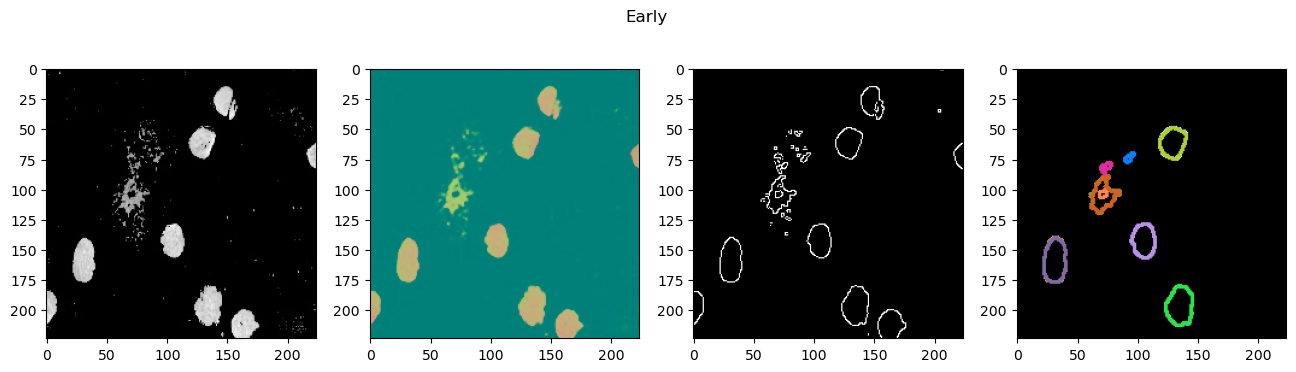

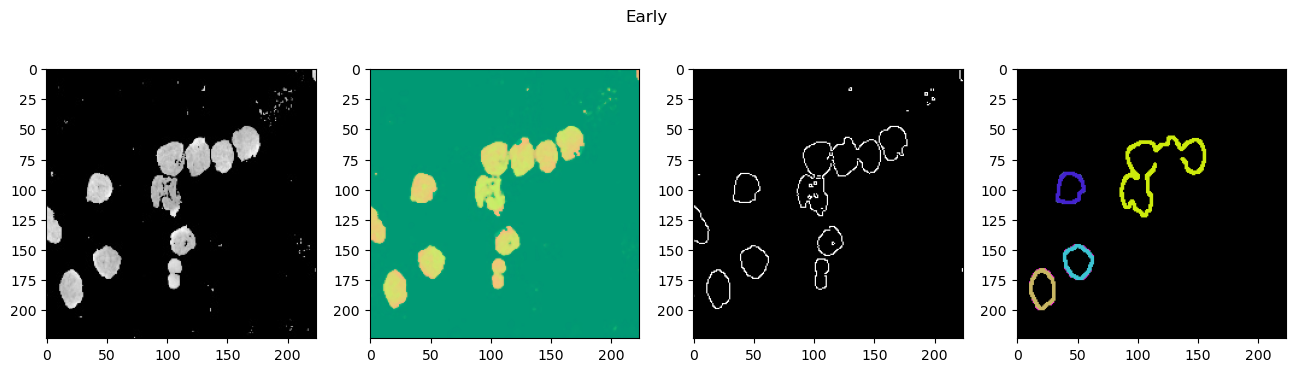

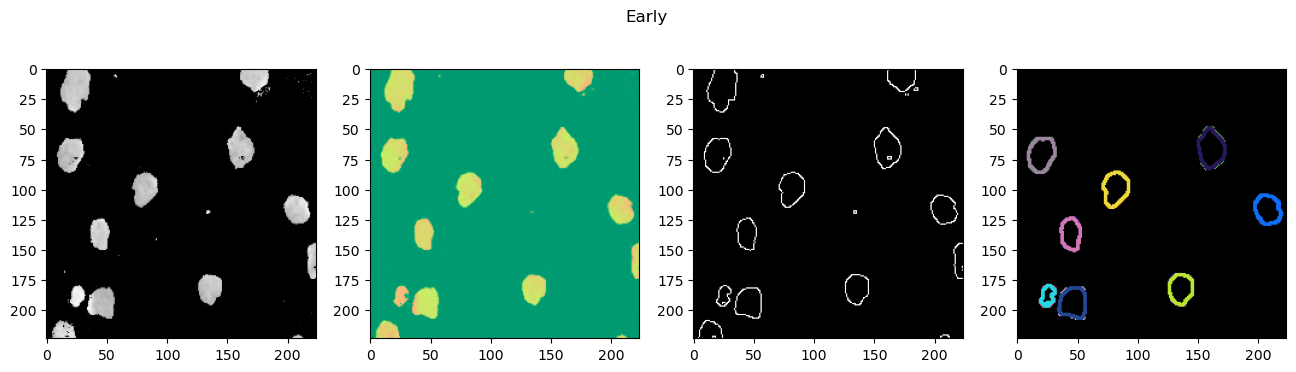

In [34]:

for index, row in df_n_standard.iterrows():
    
    src = Contour_Data(row['root'],row['class name'], 85, segmented = False, verbose = True)
    
    if index > 10: 
        
        break
    
for index, row in df_s_standard.iterrows():
    
    src = Contour_Data(row['root'], row['class name'], 85,segmented = True, verbose = True)
    
    if index > 10: 
        
        break

## Contour Features to Feature DataFrame 

In [37]:
df_n_standard['Contour Area Sum'] = 0
df_n_standard['Contour Area Mean'] = 0
df_n_standard['Contour Area Std'] = 0
df_n_standard['Contour Count'] = 0

test = df_n_standard.apply(lambda x: Contour_Data(x['root'],x['class name'], 85, segmented = False), axis = 1)

for i in range(test.shape[0]):
    
    area = test[i][0]
    mean = test[i][1]
    std = test[i][2]
    count = test[i][3]
    
    df_n_standard.iloc[i,-4] = area
    df_n_standard.iloc[i,-3] = mean
    df_n_standard.iloc[i,-2] = std
    df_n_standard.iloc[i,-1] = count
    
    area.sum(), area.mean(), area.std(), count

/var/folders/94/bxh7fj4x7yl9kbsd9mrp4n740000gn/T/ipykernel_33696/622478529.py:55: RuntimeWarning: Mean of empty slice.
  return area.sum(), area.mean(), area.std(), count
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
df_s_standard['Contour Area Sum'] = 0
df_s_standard['Contour Area Mean'] = 0
df_s_standard['Contour Area Std'] = 0
df_s_standard['Contour Count'] = 0

test = df_s_standard.apply(lambda x: Contour_Data(x['root'],x['class name'], 85, segmented = False), axis = 1)

for i in range(test.shape[0]):
    
    area = test[i][0]
    mean = test[i][1]
    std = test[i][2]
    count = test[i][3]
    
    df_s_standard.iloc[i,-4] = area
    df_s_standard.iloc[i,-3] = mean
    df_s_standard.iloc[i,-2] = std
    df_s_standard.iloc[i,-1] = count
    
    area.sum(), area.mean(), area.std(), count

/var/folders/94/bxh7fj4x7yl9kbsd9mrp4n740000gn/T/ipykernel_33696/622478529.py:55: RuntimeWarning: Mean of empty slice.
  return area.sum(), area.mean(), area.std(), count
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# HOG Features to DataFrame 

In [96]:
def HOG(image, label, thresh, segmented, verbose = False):
    
    """Return HOG, _, HOG Rescaled"""
    img = pre_process(image, segmented, verbose = False)

    img = img.mean(axis = 2) 

    
    #img = skimage.color.rgb2gray(img) # convert image to grayscale 
    
    fd, hog_image = hog(img, orientations = 8, pixels_per_cell = (2,2), 
                       cells_per_block = (1,1), visualize = True
                        ) #multichannel = False ("Channle_axis?")

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0,25))

    binary_base = hog_image.copy()
    binary_base_rs = hog_image_rescaled.copy()

    binary = binary_base[binary_base > thresh]
    
    
    mx = binary.max()
    std = binary.std()
    mean = binary.mean()
    pct = binary.shape[0]/(binary_base.shape[0]*binary_base.shape[1]) * 100 
    
    if verbose: 
        
        fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))
    
        ax[0].imshow(image)
        ax[0].set_title(f'RGB Image: {label}')

        ax[1].imshow(img, cmap = 'gray')
        ax[1].set_title(f'Grayscale: {label}')

        ax[2].imshow(hog_image_rescaled, cmap = 'gray')
        ax[2].set_title('HOG')

        fig.suptitle(f'Stage: {label}')
    
    return mx, mean, std, pct

## Add to Feature Dataset 

In [97]:
df_n_standard['HOG Max'] = 0
df_n_standard['Hog Mean'] = 0
df_n_standard['Hog Std'] = 0
df_n_standard['Hog Pct'] = 0

test = df_n_standard.apply(lambda x: HOG(x['root'],x['class name'], 0.1, segmented = False), axis = 1)

for i in range(test.shape[0]):
    
    Max = test[i][0]
    Mean = test[i][1]
    Std = test[i][2]
    Pct = test[i][3]
    
    df_n_standard.iloc[i,-4] = Max
    df_n_standard.iloc[i,-3] = Mean
    df_n_standard.iloc[i,-2] = Std
    df_n_standard.iloc[i,-1] = Pct

(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


In [98]:
df_s_standard['HOG Max'] = 0
df_s_standard['Hog Mean'] = 0
df_s_standard['Hog Std'] = 0
df_s_standard['Hog Pct'] = 0

test = df_s_standard.apply(lambda x: HOG(x['root'],x['class name'], 0.01, segmented = True), axis = 1)

for i in range(test.shape[0]):
    
    Max = test[i][0]
    Mean = test[i][1]
    Std = test[i][2]
    Pct = test[i][3]
    
    df_s_standard.iloc[i,-4] = Max
    df_s_standard.iloc[i,-3] = Mean
    df_s_standard.iloc[i,-2] = Std
    df_s_standard.iloc[i,-1] = Pct

(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224)


ValueError: zero-size array to reduction operation maximum which has no identity

## YCbCr Metrics

## LAB Metrics 

In [53]:
def LAB_met(img, label, thresh, channel, segmented,  verbose = False):
    
    img = pre_process(img, segmented, verbose = False)
    
    mask = img[:,:,channel] > thresh
    single_channel_mask = mask.astype('bool')
    
    
    #Mean, std of Y
    
    mean_y = img[:,:,0][mask].mean()
    std_y = img[:,:,0][mask].std()
    
    #mean, std of Cb 
    
    mean_cb = img[:,:,1][mask].mean()
    std_cb = img[:,:,1][mask].std()
    
    #mean, std of Cr

    mean_cr = img[:,:,2][mask].mean()
    std_cr = img[:,:,2][mask].std()
    
    masked = np.zeros((224,224,3))
    
    for i in range(mask.shape[0]):
    
        for j in range(mask.shape[1]):

            if not mask[i,j]:

                #for c in [0,1,2]:

                pass
                    
            else: 
                
                for c in [0,1,2]:
                    
                    masked[i,j,c] = img[i,j,c]

    if verbose:
        
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
        
        ax[0].imshow(src)
        ax[1].imshow(img)
        #ax[2].imshow(masked)
        
        fig.suptitle(f'{label}: LAB Blurred')

        
    return mean_y, std_y, mean_cb, std_cb, mean_cr, std_cr   #imgYCC_blur, mask

In [60]:
non_seg1 = []
non_seg2 = []
seg = []

for image, label in tqdm(zip(list(df_n_standard['root']), list(df_n_standard['class name']))):

    mean_y, std_y, mean_cb, std_cb, mean_cr, std_cr = LAB_met(image, label, 0, 1, segmented = False)
    
    non_seg1.append([label, mean_y, std_y, mean_cb, std_cb, mean_cr, std_cr])

for image, label in tqdm(zip(list(df_n_standard['root']), list(df_n_standard['class name']))):

    mean_y, std_y, mean_cb, std_cb, mean_cr, std_cr = LAB_met(image, label, 0, 2, segmented = False)
    
    non_seg2.append([label, mean_y, std_y, mean_cb, std_cb, mean_cr, std_cr])
    
for image, label in tqdm(zip(list(df_s_standard['root']), list(df_s_standard['class name']))):
    
    mean_y, std_y, mean_cb, std_cb, mean_cr, std_cr = LAB_met(image, label, 0, 0, segmented = True)
    
    seg.append([label, mean_y, std_y, mean_cb, std_cb, mean_cr, std_cr])
    
df_color_non_seg_cb = pd.DataFrame(non_seg1, columns = ['Label','Y Mean', 'Y Std', 'Cb Mean', 'Cb Std', 'Cr Mean', 'Cr Std'])

df_color_non_seg_cr = pd.DataFrame(non_seg2, columns = ['Label','Y Mean', 'Y Std', 'Cb Mean', 'Cb Std', 'Cr Mean', 'Cr Std'])

df_color_seg = pd.DataFrame(seg, columns = ['Label','Y Mean', 'Y Std', 'Cb Mean', 'Cb Std', 'Cr Mean', 'Cr Std'])
    

302it [00:08, 40.06it/s]/var/folders/94/bxh7fj4x7yl9kbsd9mrp4n740000gn/T/ipykernel_33696/2429422182.py:11: RuntimeWarning: Mean of empty slice.
  mean_y = img[:,:,0][mask].mean()
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/lucrobitaille/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/94/bxh7fj4x7

Text(0.5, 0.98, 'LAB Color Distributions, Non Segmented, A threshold')

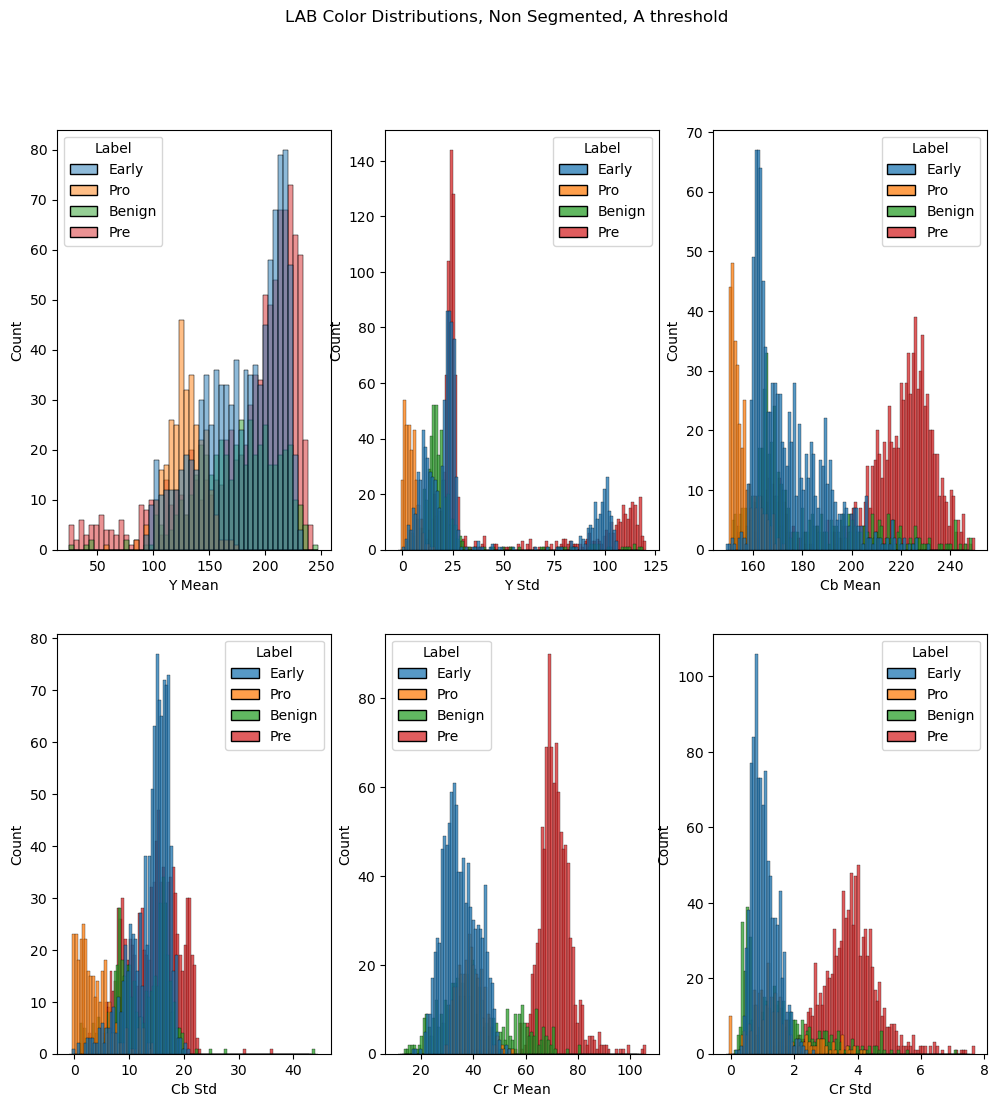

In [61]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 12))  # step, stack, dodge 

sns.histplot(ax = ax[0,0], data = df_color_non_seg_cb, x='Y Mean', hue='Label',
              shrink=1, bins=50, multiple = 'layer')

sns.histplot(ax = ax[0,1], data = df_color_non_seg_cb, x='Y Std', hue='Label',
             multiple='dodge', shrink=5, bins=100)

sns.histplot(ax = ax[0,2], data = df_color_non_seg_cb, x='Cb Mean', hue='Label',
             multiple='dodge', shrink=5, bins=100)

sns.histplot(ax = ax[1,0], data = df_color_non_seg_cb, x='Cb Std', hue='Label',
             multiple='dodge', shrink=5, bins=100)

sns.histplot(ax = ax[1,1], data = df_color_non_seg_cb, x='Cr Mean', hue='Label',
             multiple='dodge', shrink=5, bins=100)

sns.histplot(ax = ax[1,2], data = df_color_non_seg_cb, x='Cr Std', hue='Label',
             multiple='dodge', shrink=5, bins=100)

fig.suptitle('LAB Color Distributions, Non Segmented, A threshold')

Text(0.5, 0.98, 'LAB Color Distributions, Non Segmented')

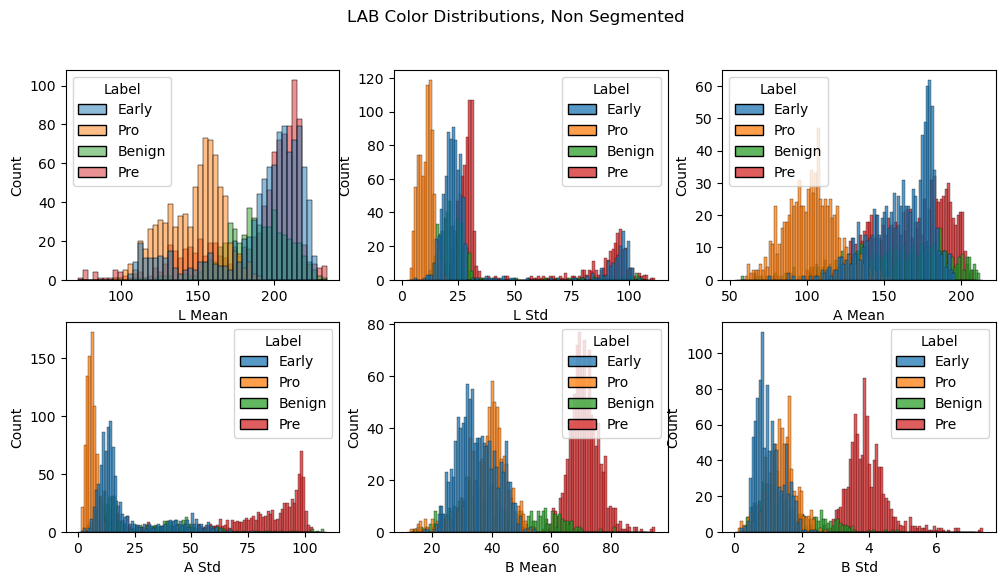

In [82]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 6))  # step, stack, dodge 

sns.histplot(ax = ax[0,0], data = df_color_non_seg_cr, x='Y Mean', hue='Label',
              shrink=1, bins=50, multiple = 'layer')

ax[0,0].set_xlabel('L Mean')

sns.histplot(ax = ax[0,1], data = df_color_non_seg_cr, x='Y Std', hue='Label',
             multiple='dodge', shrink=5, bins=100)

ax[0,1].set_xlabel('L Std')

sns.histplot(ax = ax[0,2], data = df_color_non_seg_cr, x='Cb Mean', hue='Label',
             multiple='dodge', shrink=5, bins=100)

ax[0,2].set_xlabel('A Mean')

sns.histplot(ax = ax[1,0], data = df_color_non_seg_cr, x='Cb Std', hue='Label',
             multiple='dodge', shrink=5, bins=100)

ax[1,0].set_xlabel('A Std')

sns.histplot(ax = ax[1,1], data = df_color_non_seg_cr, x='Cr Mean', hue='Label',
             multiple='dodge', shrink=5, bins=100)

ax[1,1].set_xlabel('B Mean')

sns.histplot(ax = ax[1,2], data = df_color_non_seg_cr, x='Cr Std', hue='Label',
             multiple='dodge', shrink=5, bins=100)

ax[1,2].set_xlabel('B Std')

fig.suptitle('LAB Color Distributions, Non Segmented')

Text(0.5, 0.98, 'LAB Color Distributions, Segmented, L threshold')

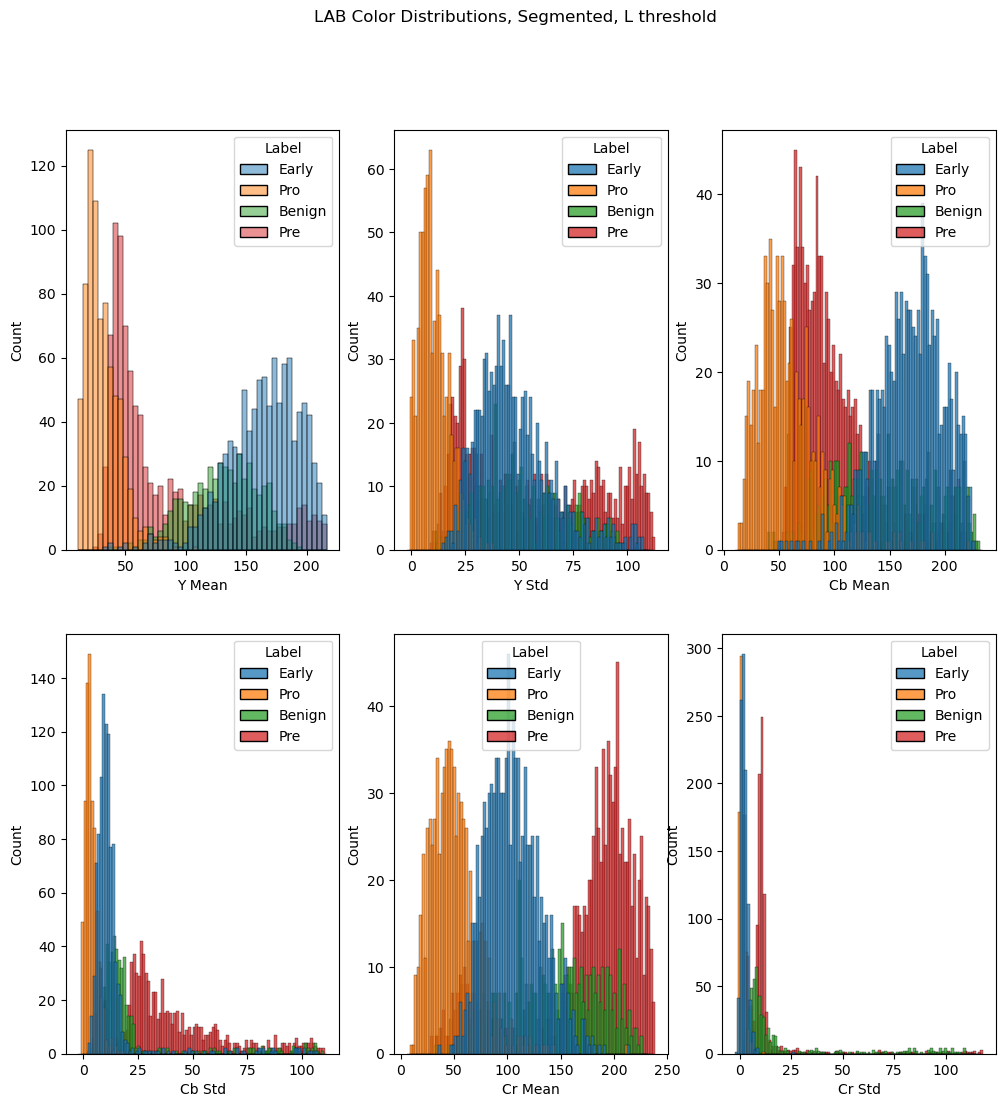

In [63]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 12))  # step, stack, dodge 

sns.histplot(ax = ax[0,0], data = df_color_seg, x='L Mean', hue='Label',
              shrink=1, bins=50, multiple = 'layer')

sns.histplot(ax = ax[0,1], data = df_color_seg, x='L Std', hue='Label',
             multiple='dodge', shrink=5, bins=100)

sns.histplot(ax = ax[0,2], data = df_color_seg, x='A Mean', hue='Label',
             multiple='dodge', shrink=5, bins=100)

sns.histplot(ax = ax[1,0], data = df_color_seg, x='A Std', hue='Label',
             multiple='dodge', shrink=5, bins=100)

sns.histplot(ax = ax[1,1], data = df_color_seg, x='B Mean', hue='Label',
             multiple='dodge', shrink=5, bins=100)

sns.histplot(ax = ax[1,2], data = df_color_seg, x='B Std', hue='Label',
             multiple='dodge', shrink=5, bins=100)

fig.suptitle('LAB Color Distributions, Segmented')

In [67]:
df_n_standard['Y mean no thresh'] = 0
df_n_standard['Y Std no thresh'] = 0

df_n_standard['Cb Mean no thresh'] = 0
df_n_standard['Cb Std no thresh'] = 0

df_n_standard['Cr Mean no thresh'] = 0
df_n_standard['Cr Std no thresh'] = 0

test = df_n_standard.apply(lambda x: LAB_met(x['root'],x['class name'], 0, 2, segmented = False), axis = 1)

for i in range(test.shape[0]):
    
    Cr_Mean = test[i][4]
    Cr_Std = test[i][5]
    
    Cb_Mean = test[i][2]
    Cb_Std = test[i][3]
    
    Y_Mean = test[i][0]
    Y_Std = test[i][1]
    
    df_n_standard.iloc[i,-6] = Y_Mean
    df_n_standard.iloc[i,-5] = Y_Std
    
    df_n_standard.iloc[i,-4] = Cb_Mean
    df_n_standard.iloc[i,-3] = Cb_Std
    
    df_n_standard.iloc[i,-2] = Cr_Mean
    df_n_standard.iloc[i,-1] = Cr_Std
    
    

In [68]:
df_s_standard['Y mean no thresh'] = 0
df_s_standard['Y Std no thresh'] = 0

df_s_standard['Cb Mean no thresh'] = 0
df_s_standard['Cb Std no thresh'] = 0

df_s_standard['Cr Mean no thresh'] = 0
df_s_standard['Cr Std no thresh'] = 0

test = df_n_standard.apply(lambda x: LAB_met(x['root'],x['class name'], 0, 2, segmented = True), axis = 1)

for i in range(test.shape[0]):
    
    Cr_Mean = test[i][4]
    Cr_Std = test[i][5]
    
    Cb_Mean = test[i][2]
    Cb_Std = test[i][3]
    
    Y_Mean = test[i][0]
    Y_Std = test[i][1]
    
    df_s_standard.iloc[i,-6] = Y_Mean
    df_s_standard.iloc[i,-5] = Y_Std
    
    df_s_standard.iloc[i,-4] = Cb_Mean
    df_s_standard.iloc[i,-3] = Cb_Std
    
    df_s_standard.iloc[i,-2] = Cr_Mean
    df_s_standard.iloc[i,-1] = Cr_Std
    

# Save off feature dataframes 

In [ ]:
df_n_standard.fillna(0, inplace = True)
df_s_standard.fillna(0, inplace = True)

In [ ]:
df_n_standard.to_csv('Non_Segmented_Features_Standardized_he.csv', index = False)
df_s_standard.to_csv('Segmented_Features_Standardized_he.csv', index = False)

In [ ]:
print(df_n_standard.shape, df_s_standard.shape)

## Compare YCbCr pre-processed to non-processed: 

In [ ]:
df_n_standard.shape, df_s_standard.shape